# WeatherPy
The goal of WeatherPy is to look at the correlation between weather and latitude. The notebooks gets temperatures, humitdities, % cloud coverages and wind speeds for cities using the Open Weather API and plots the data vs latitute. 
***
## Set Up
To start, we load dependencies and define all functions to be used later.

In [1]:
from api_keys import api_key
import requests
import random as r
import numpy as np
import pandas as pd
from time import sleep
from datetime import date as dt
from citipy import citipy as cp
from matplotlib import pyplot as plt
from scipy import stats as st

The function smart_lat is used to randomly generate latitudes with a distribution that is slightly skewed toward latitudes with more cities. This is mostly done to limit selecting the same cities over and over because of the population scaricty at those latitudes. The will be a more rigorous way to eliminate duplicate cities below.

In [2]:
# Create a fcunction to produce latitudes in realistic areas
def smart_lat():
    return 110/np.pi*np.arcsin((2*r.random()-1))

The function get_city takes a latitude and longitude coordinate and finds the closest city using citipy. If coordinates are not givin, the latitude and longitude are randomly generated. If 'smart' is selected for latitude, the smart_lat function is called and produces a random latitude from a favorable distribution. It returns the city name.

In [3]:
# Create a function that gets the closest city to a coordinate point
def get_city(lat='random', lon='random'):
    
    # If lat is not given use random latitude
    if lat == 'random':
        lat = 180*(r.random()-.5)
    if lat == 'smart':
        lat = smart_lat()

    # If lon is not given use random longitude
    if lon == 'random':
        lon = 360*(r.random()-.5)

    # Get nearest city to coordinates
    city = cp.nearest_city(lat, lon)
    
    # Return the name of the city
    return f'{city.city_name.capitalize()}, {city.country_code.upper()}'

The function is_duplicate checks if a givin item is in a givin list.

In [4]:
# Create a function to check if sample city is arealdy in list
def is_duplicate(item, items):
        
    # Check if the sample city is in list...
    if item in items:
                
        # retrun true
        return True
    
    # Otherwise...
    else:
    
        # return false
        return False

The function get_city_info takes the name of a city and returns the coordinates for that city using the Open Weather geocoding api call.

In [5]:
# Create a function to get a city coords
def get_city_info(query):
    
    # Geocoder base api access point
    geo_query_url = f'http://api.openweathermap.org/geo/1.0/direct?appid={api_key}&q='
    
    # Call geocoder api
    response = requests.get(f'{geo_query_url}{query}').json()[0]
    
    # Return name, lat and lon as dictionary
    return {'name': f"{response['name']}, {response['country']}",
            'lat': response['lat'],
            'lon': response['lon']}

The function get_city_weather gets the weather data (temperature, humidity, cloudiness, wind speed) for a givin city using the Open Weather current weather api call.

In [6]:
# Create a function to get weather at a city (with lon/lat for city)
def get_city_weather(city_info, units='imperial'):
    
    # Get lon and lat from city info
    lat = city_info['lat']
    lon = city_info['lon']
    
    # Base url to get weatehr by lon/lat
    weather_url = f'https://api.openweathermap.org/data/2.5/weather?units={units}&appid={api_key}&'
    
    # Call open weather api
    response = requests.get(f'{weather_url}lat={lat}&lon={lon}').json()
    
    return {'temp': response['main']['temp'],
            'humidity': response['main']['humidity'],
            'clouds': response['clouds']['all'],
            'wind_speed':response['wind']['speed']}

The function get_weather_vs_lat combines the above function to produce a dataframe that stores coordinates and weather data for a givin number of cities. 

In [7]:
# Create a function to gather city and weather info and package as a dataframe
def  get_weather_vs_lat(num_of_rows):
    
    # Get today's date
    today = dt.today()
    print(f"Looking for weather info for {num_of_rows} cities. Today's date is {today}.\n-------------------------------------------------------------------------------------")
    
    # Intitailize initial value(s) and lists
    success_count = 0
    attempt_count = 0
    cities = []
    city_names = []
    lats = []
    lons = []
    temps = []
    humidities = []
    clouds_list = []
    wind_speeds = []

    # Loop until limit is reached
    while success_count < num_of_rows:
        
        # Increment attempt counter
        attempt_count += 1
        
        # Get city closest to a random point on globe where lat is between -60 and +60 and lon is uniform random between -180 and +180
        city = get_city(lat='smart')
        
        print(f'Attempt number {attempt_count} for city number {success_count + 1}.')
        print(f'Selecting nearest city to random coordinates... Success: City is {city}.')
        
        # If random city is duplicate, go back to start of loop and try again
        if is_duplicate(city, cities): 
            print(f'Checking if selected city is unique... Failed: {city} is already on list!')
            continue
        else:
            
            print(f'Checking if selected city is unique... Success: {city} is not on list already.')
            # If city is unique, add it to the list of cities queried so it does not appear again
            cities.append(city)
            
            # Try to get the city info (cleaned up name, latitude, longitude)
            try:
                city_info = get_city_info(city)
                
                # Wait for 1 sec to help with 
                sleep(1)
                
                print(f"Getting city information... Success: Found {city} at {city_info['lat']}, {city_info['lon']}.")
            
            # If city info is not available for the target city, got back to the start of the loop and try again
            except IndexError as error: 
                print(f'Getting city information... Failed: Cannot find coordinates for {city}!')
                continue
            
            # As long as city info is obtained successfully, get the weather for the city
            city_weather = get_city_weather(city_info)
            print(f'Getting weather information... Success: Added weather info for {city}.\n-------------------------------------------------------------------------------------')
            
            # Wait 1 sec to adhere to api rate limiting
            sleep(1)

            # Add current info to list
            city_names.append(city_info['name'])
            lats.append(city_info['lat'])
            lons.append(city_info['lon'])
            temps.append(city_weather['temp'])
            humidities.append(city_weather['humidity'])
            clouds_list.append(city_weather['clouds'])
            wind_speeds.append(city_weather['wind_speed'])

            # Increment because a city's info and weather was successfully added and reset attempts
            success_count += 1
            attempt_count = 0

    # Create df from lists
    degrees = '\u00B0'
    return pd.DataFrame({'city': city_names,
                         f'latitude ({degrees}N)': lats,
                         f'longitude ({degrees}E)': lons,
                         f'temperature ({degrees}F)': temps,
                         'humidity (%)': humidities, 
                         'cloudiness (%)': clouds_list,
                         'wind speed (mph)': wind_speeds})

The function scatter is used plots two columns of a given dataframe as a scatter plot. The keyword argument 'subsett' is used to select postive (North), negative (South) or all latitudes. The keyword argument 'regress' is a boolean; if True, a linnear regression is drawn. 

In [8]:
# Create a function to print a scatter plot
def scatter(dataframe, col1, col2, subcol='', regress=False, subset='all', units='imperial', save=False):
    plot_type = 'Scatter plot'
    today = dt.today()
    if subcol == '':
        subcol = col1
    if subset == 'all':
        dataframe_sub = dataframe
    if subset == 'positive':
        dataframe_sub = dataframe.loc[dataframe[subcol] >= 0, :]
    if subset == 'negative':
        dataframe_sub = dataframe.loc[dataframe[subcol] < 0, :]
    if isinstance(subset, int):
        dataframe_sub = dataframe.loc[np.abs(dataframe[subcol] - subset) < 7.5, :]
    x = dataframe_sub[col1]
    y = dataframe_sub[col2]
    plt.scatter(x, y, alpha=.5)
    x_mar = 1/20*(max(x) - min(x))
    y_mar = 1/10*(max(y) - min(y))
    plt.xlim(min(x) - x_mar,max(x) + x_mar)
    plt.ylim(min(y) - y_mar,max(y) + y_mar)
    plt.xlabel(col1)
    plt.ylabel(col2)
    if regress == True:
        m, b, r, p, e = st.linregress(x, y)
        x_lin = [-180, 180]
        y_hat = [m*x+b for x in x_lin]
        y_hat_sym = "\u0177"
        y_hat_eq = f'{y_hat_sym}={round(m, 2)}*x+{round(b, 2)}, p={"{:.2e}".format(p)}, r={round(r, 2)}'
        x_a = min(x) + x_mar
        y_a = max(y) - y_mar
        plt.plot(x_lin, y_hat, c='red')
        plt.annotate(y_hat_eq, (x_a, y_a), c='red')
        plot_type = 'Regression'
    plt.title(f'{plot_type} of {col2} vs {col1}\n for {subset} {subcol} on {today}')
    if save:
        fname = f'Output/{col2}_vs_{col1}_subset_{subset}_regress_{regress}'
        plt.savefig(fname)
    plt.show()

## Gather Data
The dataframe, weather_data, is generated with the get_weather_vs_lat function.

In [9]:
weather_data = get_weather_vs_lat(500)

Looking for weather info for 500 cities. Today's date is 2022-08-16.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 1.
Selecting nearest city to random coordinates... Success: City is Hambantota, LK.
Checking if selected city is unique... Success: Hambantota, LK is not on list already.
Getting city information... Success: Found Hambantota, LK at 6.1249126, 81.1242563.
Getting weather information... Success: Added weather info for Hambantota, LK.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 2.
Selecting nearest city to random coordinates... Success: City is Bagula, IN.
Checking if selected city is unique... Success: Bagula, IN is not on list already.
Getting city information... Success: Found Bagula, IN at 23.3338687, 88.642096.
Getting weather information... Success: Added weather info for Bagula, IN.
-----------------------------------------

Attempt number 1 for city number 17.
Selecting nearest city to random coordinates... Success: City is Kapaa, US.
Checking if selected city is unique... Success: Kapaa, US is not on list already.
Getting city information... Success: Found Kapaa, US at 22.0747334, -159.3191601.
Getting weather information... Success: Added weather info for Kapaa, US.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 18.
Selecting nearest city to random coordinates... Success: City is Palu, ID.
Checking if selected city is unique... Success: Palu, ID is not on list already.
Getting city information... Success: Found Palu, ID at -0.8957793, 119.8679974.
Getting weather information... Success: Added weather info for Palu, ID.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 19.
Selecting nearest city to random coordinates... Success: City is Shakawe, BW.
Checking if sele

Attempt number 1 for city number 35.
Selecting nearest city to random coordinates... Success: City is Puerto ayora, EC.
Checking if selected city is unique... Success: Puerto ayora, EC is not on list already.
Getting city information... Success: Found Puerto ayora, EC at -0.7471674, -90.3134198.
Getting weather information... Success: Added weather info for Puerto ayora, EC.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 36.
Selecting nearest city to random coordinates... Success: City is Mayumba, GA.
Checking if selected city is unique... Success: Mayumba, GA is not on list already.
Getting city information... Success: Found Mayumba, GA at -3.4310453, 10.6543709.
Getting weather information... Success: Added weather info for Mayumba, GA.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 37.
Selecting nearest city to random coordinates... Success:

Attempt number 1 for city number 50.
Selecting nearest city to random coordinates... Success: City is Gambela, ET.
Checking if selected city is unique... Success: Gambela, ET is not on list already.
Getting city information... Success: Found Gambela, ET at 8.2503656, 34.5877344.
Getting weather information... Success: Added weather info for Gambela, ET.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 51.
Selecting nearest city to random coordinates... Success: City is San juan, US.
Checking if selected city is unique... Success: San juan, US is not on list already.
Getting city information... Success: Found San juan, US at 18.465299, -66.116666.
Getting weather information... Success: Added weather info for San juan, US.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 52.
Selecting nearest city to random coordinates... Success: City is Vaini, TO.

Getting city information... Success: Found Takoradi, GH at 4.887401, -1.7519316.
Getting weather information... Success: Added weather info for Takoradi, GH.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 66.
Selecting nearest city to random coordinates... Success: City is Touros, BR.
Checking if selected city is unique... Success: Touros, BR is not on list already.
Getting city information... Success: Found Touros, BR at -5.1998625, -35.4595051.
Getting weather information... Success: Added weather info for Touros, BR.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 67.
Selecting nearest city to random coordinates... Success: City is Manggar, ID.
Checking if selected city is unique... Success: Manggar, ID is not on list already.
Getting city information... Success: Found Manggar, ID at -2.8672641, 108.2759285.
Getting weather information... Suc

Getting city information... Success: Found Basoko, CD at -3.291524, 17.460055783543147.
Getting weather information... Success: Added weather info for Basoko, CD.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 82.
Selecting nearest city to random coordinates... Success: City is Atuona, PF.
Checking if selected city is unique... Failed: Atuona, PF is already on list!
Attempt number 2 for city number 82.
Selecting nearest city to random coordinates... Success: City is Gasa, BT.
Checking if selected city is unique... Success: Gasa, BT is not on list already.
Getting city information... Success: Found Gasa, BT at 27.9057587, 89.7293569.
Getting weather information... Success: Added weather info for Gasa, BT.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 83.
Selecting nearest city to random coordinates... Success: City is Castro, CL.
Checking if se

Attempt number 1 for city number 96.
Selecting nearest city to random coordinates... Success: City is Maumere, ID.
Checking if selected city is unique... Success: Maumere, ID is not on list already.
Getting city information... Success: Found Maumere, ID at -8.6256456, 122.2192885.
Getting weather information... Success: Added weather info for Maumere, ID.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 97.
Selecting nearest city to random coordinates... Success: City is Antalya, TR.
Checking if selected city is unique... Success: Antalya, TR is not on list already.
Getting city information... Success: Found Antalya, TR at 36.9009641, 30.6954846.
Getting weather information... Success: Added weather info for Antalya, TR.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 98.
Selecting nearest city to random coordinates... Success: City is Jamestown, 

Attempt number 1 for city number 111.
Selecting nearest city to random coordinates... Success: City is Cidreira, BR.
Checking if selected city is unique... Success: Cidreira, BR is not on list already.
Getting city information... Success: Found Cidreira, BR at -30.1657063, -50.218331.
Getting weather information... Success: Added weather info for Cidreira, BR.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 112.
Selecting nearest city to random coordinates... Success: City is Faya, TD.
Checking if selected city is unique... Failed: Faya, TD is already on list!
Attempt number 2 for city number 112.
Selecting nearest city to random coordinates... Success: City is Huaicheng, CN.
Checking if selected city is unique... Success: Huaicheng, CN is not on list already.
Getting city information... Success: Found Huaicheng, CN at 33.5380122, 119.1324859.
Getting weather information... Success: Added weather info for Huaicheng,

Getting city information... Success: Found Mogadishu, SO at 2.0349312, 45.3419183.
Getting weather information... Success: Added weather info for Mogadishu, SO.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 124.
Selecting nearest city to random coordinates... Success: City is Carnarvon, AU.
Checking if selected city is unique... Failed: Carnarvon, AU is already on list!
Attempt number 2 for city number 124.
Selecting nearest city to random coordinates... Success: City is Jamestown, SH.
Checking if selected city is unique... Failed: Jamestown, SH is already on list!
Attempt number 3 for city number 124.
Selecting nearest city to random coordinates... Success: City is Hithadhoo, MV.
Checking if selected city is unique... Failed: Hithadhoo, MV is already on list!
Attempt number 4 for city number 124.
Selecting nearest city to random coordinates... Success: City is Qingyuan, CN.
Checking if selected city is unique... 

Getting weather information... Success: Added weather info for Cascais, PT.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 138.
Selecting nearest city to random coordinates... Success: City is Jamestown, SH.
Checking if selected city is unique... Failed: Jamestown, SH is already on list!
Attempt number 2 for city number 138.
Selecting nearest city to random coordinates... Success: City is Mao, TD.
Checking if selected city is unique... Success: Mao, TD is not on list already.
Getting city information... Success: Found Mao, TD at 14.1234161, 15.3108471.
Getting weather information... Success: Added weather info for Mao, TD.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 139.
Selecting nearest city to random coordinates... Success: City is Bitung, ID.
Checking if selected city is unique... Success: Bitung, ID is not on list already.
Getting city 

Getting city information... Success: Found Palabuhanratu, ID at -6.9882409, 106.5503728.
Getting weather information... Success: Added weather info for Palabuhanratu, ID.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 152.
Selecting nearest city to random coordinates... Success: City is Mahibadhoo, MV.
Checking if selected city is unique... Success: Mahibadhoo, MV is not on list already.
Getting city information... Success: Found Mahibadhoo, MV at 3.7572355, 72.9689431887705.
Getting weather information... Success: Added weather info for Mahibadhoo, MV.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 153.
Selecting nearest city to random coordinates... Success: City is Ribeira grande, PT.
Checking if selected city is unique... Failed: Ribeira grande, PT is already on list!
Attempt number 2 for city number 153.
Selecting nearest city to random co

Getting city information... Success: Found Charters towers, AU at -20.0714089, 146.2709824.
Getting weather information... Success: Added weather info for Charters towers, AU.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 166.
Selecting nearest city to random coordinates... Success: City is Luderitz, NA.
Checking if selected city is unique... Failed: Luderitz, NA is already on list!
Attempt number 2 for city number 166.
Selecting nearest city to random coordinates... Success: City is Nioro, ML.
Checking if selected city is unique... Success: Nioro, ML is not on list already.
Getting city information... Success: Found Nioro, ML at 15.2304528, -9.5899063.
Getting weather information... Success: Added weather info for Nioro, ML.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 167.
Selecting nearest city to random coordinates... Success: City is Pu

Getting city information... Failed: Cannot find coordinates for Sentyabrskiy, RU!
Attempt number 4 for city number 180.
Selecting nearest city to random coordinates... Success: City is Broken hill, AU.
Checking if selected city is unique... Success: Broken hill, AU is not on list already.
Getting city information... Success: Found Broken hill, AU at -31.965, 141.4511111.
Getting weather information... Success: Added weather info for Broken hill, AU.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 181.
Selecting nearest city to random coordinates... Success: City is Porbandar, IN.
Checking if selected city is unique... Success: Porbandar, IN is not on list already.
Getting city information... Success: Found Porbandar, IN at 21.6409, 69.611.
Getting weather information... Success: Added weather info for Porbandar, IN.
-------------------------------------------------------------------------------------
Attempt number 

Getting weather information... Success: Added weather info for Moron, MN.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 196.
Selecting nearest city to random coordinates... Success: City is Orocue, CO.
Checking if selected city is unique... Success: Orocue, CO is not on list already.
Getting city information... Success: Found Orocue, CO at 4.789484, -71.3406351.
Getting weather information... Success: Added weather info for Orocue, CO.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 197.
Selecting nearest city to random coordinates... Success: City is Tukrah, LY.
Checking if selected city is unique... Success: Tukrah, LY is not on list already.
Getting city information... Success: Found Tukrah, LY at 32.532222, 20.572222.
Getting weather information... Success: Added weather info for Tukrah, LY.
-------------------------------------------------

Attempt number 1 for city number 209.
Selecting nearest city to random coordinates... Success: City is Beja, PT.
Checking if selected city is unique... Success: Beja, PT is not on list already.
Getting city information... Success: Found Beja, PT at 38.0154479, -7.8650368.
Getting weather information... Success: Added weather info for Beja, PT.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 210.
Selecting nearest city to random coordinates... Success: City is Nelson bay, AU.
Checking if selected city is unique... Success: Nelson bay, AU is not on list already.
Getting city information... Success: Found Nelson bay, AU at -32.7218138, 152.1440889.
Getting weather information... Success: Added weather info for Nelson bay, AU.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 211.
Selecting nearest city to random coordinates... Success: City is Bur gab

Getting city information... Success: Found Diapaga, BF at 12.0713223, 1.7883859.
Getting weather information... Success: Added weather info for Diapaga, BF.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 222.
Selecting nearest city to random coordinates... Success: City is Saint george, BM.
Checking if selected city is unique... Failed: Saint george, BM is already on list!
Attempt number 2 for city number 222.
Selecting nearest city to random coordinates... Success: City is Trairi, BR.
Checking if selected city is unique... Success: Trairi, BR is not on list already.
Getting city information... Success: Found Trairi, BR at -3.2741504, -39.2649188.
Getting weather information... Success: Added weather info for Trairi, BR.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 223.
Selecting nearest city to random coordinates... Success: City is Rikitea,

Getting city information... Success: Found Lamu, KE at -2.2675396, 40.9010641.
Getting weather information... Success: Added weather info for Lamu, KE.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 235.
Selecting nearest city to random coordinates... Success: City is Linhares, BR.
Checking if selected city is unique... Failed: Linhares, BR is already on list!
Attempt number 2 for city number 235.
Selecting nearest city to random coordinates... Success: City is Puerto ayora, EC.
Checking if selected city is unique... Failed: Puerto ayora, EC is already on list!
Attempt number 3 for city number 235.
Selecting nearest city to random coordinates... Success: City is Kapaa, US.
Checking if selected city is unique... Failed: Kapaa, US is already on list!
Attempt number 4 for city number 235.
Selecting nearest city to random coordinates... Success: City is Olinda, BR.
Checking if selected city is unique... Success: Olinda

Getting city information... Success: Found Filotion, GR at 37.0513568, 25.4983474.
Getting weather information... Success: Added weather info for Filotion, GR.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 248.
Selecting nearest city to random coordinates... Success: City is Ribeira grande, PT.
Checking if selected city is unique... Failed: Ribeira grande, PT is already on list!
Attempt number 2 for city number 248.
Selecting nearest city to random coordinates... Success: City is Karratha, AU.
Checking if selected city is unique... Failed: Karratha, AU is already on list!
Attempt number 3 for city number 248.
Selecting nearest city to random coordinates... Success: City is Shingu, JP.
Checking if selected city is unique... Success: Shingu, JP is not on list already.
Getting city information... Success: Found Shingu, JP at 33.7241003, 135.9930029.
Getting weather information... Success: Added weather info for Shing

Attempt number 1 for city number 259.
Selecting nearest city to random coordinates... Success: City is Pacifica, US.
Checking if selected city is unique... Success: Pacifica, US is not on list already.
Getting city information... Success: Found Pacifica, US at 37.6138253, -122.4869194.
Getting weather information... Success: Added weather info for Pacifica, US.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 260.
Selecting nearest city to random coordinates... Success: City is Vaini, TO.
Checking if selected city is unique... Failed: Vaini, TO is already on list!
Attempt number 2 for city number 260.
Selecting nearest city to random coordinates... Success: City is Hilo, US.
Checking if selected city is unique... Failed: Hilo, US is already on list!
Attempt number 3 for city number 260.
Selecting nearest city to random coordinates... Success: City is Mar del plata, AR.
Checking if selected city is unique... Success: 

Attempt number 1 for city number 273.
Selecting nearest city to random coordinates... Success: City is Hamtic, PH.
Checking if selected city is unique... Success: Hamtic, PH is not on list already.
Getting city information... Success: Found Hamtic, PH at 10.7006934, 121.9810968.
Getting weather information... Success: Added weather info for Hamtic, PH.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 274.
Selecting nearest city to random coordinates... Success: City is Auki, SB.
Checking if selected city is unique... Failed: Auki, SB is already on list!
Attempt number 2 for city number 274.
Selecting nearest city to random coordinates... Success: City is Sola, VU.
Checking if selected city is unique... Failed: Sola, VU is already on list!
Attempt number 3 for city number 274.
Selecting nearest city to random coordinates... Success: City is Broken hill, AU.
Checking if selected city is unique... Failed: Broken hill, A

Getting city information... Success: Found Shimoda, JP at 34.679545, 138.945379.
Getting weather information... Success: Added weather info for Shimoda, JP.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 286.
Selecting nearest city to random coordinates... Success: City is Hilo, US.
Checking if selected city is unique... Failed: Hilo, US is already on list!
Attempt number 2 for city number 286.
Selecting nearest city to random coordinates... Success: City is Cockburn harbour, TC.
Checking if selected city is unique... Success: Cockburn harbour, TC is not on list already.
Getting city information... Success: Found Cockburn harbour, TC at 21.498342, -71.5296449.
Getting weather information... Success: Added weather info for Cockburn harbour, TC.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 287.
Selecting nearest city to random coordinates... Su

Getting city information... Failed: Cannot find coordinates for Paradwip, IN!
Attempt number 3 for city number 298.
Selecting nearest city to random coordinates... Success: City is Hobyo, SO.
Checking if selected city is unique... Failed: Hobyo, SO is already on list!
Attempt number 4 for city number 298.
Selecting nearest city to random coordinates... Success: City is Saleilua, WS.
Checking if selected city is unique... Success: Saleilua, WS is not on list already.
Getting city information... Success: Found Saleilua, WS at -14.0287745, -171.6987002.
Getting weather information... Success: Added weather info for Saleilua, WS.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 299.
Selecting nearest city to random coordinates... Success: City is Casian, PH.
Checking if selected city is unique... Success: Casian, PH is not on list already.
Getting city information... Success: Found Casian, PH at 11.0376765, 119.7121825.


Getting weather information... Success: Added weather info for Monrovia, LR.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 312.
Selecting nearest city to random coordinates... Success: City is Bethel, US.
Checking if selected city is unique... Failed: Bethel, US is already on list!
Attempt number 2 for city number 312.
Selecting nearest city to random coordinates... Success: City is Ondjiva, AO.
Checking if selected city is unique... Success: Ondjiva, AO is not on list already.
Getting city information... Success: Found Ondjiva, AO at -17.0705234, 15.7280115.
Getting weather information... Success: Added weather info for Ondjiva, AO.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 313.
Selecting nearest city to random coordinates... Success: City is Sao joao da barra, BR.
Checking if selected city is unique... Success: Sao joao da barra, BR is 

Getting city information... Success: Found Port blair, IN at 11.6645348, 92.7390448.
Getting weather information... Success: Added weather info for Port blair, IN.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 324.
Selecting nearest city to random coordinates... Success: City is Ibra, OM.
Checking if selected city is unique... Success: Ibra, OM is not on list already.
Getting city information... Success: Found Ibra, OM at 22.6895878, 58.5469793.
Getting weather information... Success: Added weather info for Ibra, OM.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 325.
Selecting nearest city to random coordinates... Success: City is Samarai, PG.
Checking if selected city is unique... Failed: Samarai, PG is already on list!
Attempt number 2 for city number 325.
Selecting nearest city to random coordinates... Success: City is Kapaa, US.
Checking 

Getting city information... Success: Found Aswan, EG at 24.091071, 32.897306.
Getting weather information... Success: Added weather info for Aswan, EG.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 337.
Selecting nearest city to random coordinates... Success: City is Gorontalo, ID.
Checking if selected city is unique... Success: Gorontalo, ID is not on list already.
Getting city information... Success: Found Gorontalo, ID at 0.5384433, 123.0594971.
Getting weather information... Success: Added weather info for Gorontalo, ID.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 338.
Selecting nearest city to random coordinates... Success: City is Airai, PW.
Checking if selected city is unique... Failed: Airai, PW is already on list!
Attempt number 2 for city number 338.
Selecting nearest city to random coordinates... Success: City is San borja, BO.
C

Getting city information... Failed: Cannot find coordinates for Tiarei, PF!
Attempt number 2 for city number 350.
Selecting nearest city to random coordinates... Success: City is Kanniyakumari, IN.
Checking if selected city is unique... Success: Kanniyakumari, IN is not on list already.
Getting city information... Failed: Cannot find coordinates for Kanniyakumari, IN!
Attempt number 3 for city number 350.
Selecting nearest city to random coordinates... Success: City is Vaitupu, WF.
Checking if selected city is unique... Failed: Vaitupu, WF is already on list!
Attempt number 4 for city number 350.
Selecting nearest city to random coordinates... Success: City is Kahului, US.
Checking if selected city is unique... Failed: Kahului, US is already on list!
Attempt number 5 for city number 350.
Selecting nearest city to random coordinates... Success: City is Namatanai, PG.
Checking if selected city is unique... Failed: Namatanai, PG is already on list!
Attempt number 6 for city number 350.
Se

Getting city information... Success: Found Kitale, KE at 1.018076, 35.000236.
Getting weather information... Success: Added weather info for Kitale, KE.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 361.
Selecting nearest city to random coordinates... Success: City is Katsuura, JP.
Checking if selected city is unique... Success: Katsuura, JP is not on list already.
Getting city information... Success: Found Katsuura, JP at 35.1521846, 140.3207449.
Getting weather information... Success: Added weather info for Katsuura, JP.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 362.
Selecting nearest city to random coordinates... Success: City is Ngukurr, AU.
Checking if selected city is unique... Success: Ngukurr, AU is not on list already.
Getting city information... Success: Found Ngukurr, AU at -14.7341439, 134.7323402.
Getting weather information.

Getting city information... Success: Found Jega, NG at 12.2250004, 4.3775587.
Getting weather information... Success: Added weather info for Jega, NG.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 376.
Selecting nearest city to random coordinates... Success: City is Georgetown, SH.
Checking if selected city is unique... Failed: Georgetown, SH is already on list!
Attempt number 2 for city number 376.
Selecting nearest city to random coordinates... Success: City is Taolanaro, MG.
Checking if selected city is unique... Failed: Taolanaro, MG is already on list!
Attempt number 3 for city number 376.
Selecting nearest city to random coordinates... Success: City is Katsuura, JP.
Checking if selected city is unique... Failed: Katsuura, JP is already on list!
Attempt number 4 for city number 376.
Selecting nearest city to random coordinates... Success: City is La palma, PA.
Checking if selected city is unique... Success: L

Getting city information... Success: Found Luanda, AO at -8.8272699, 13.2439512.
Getting weather information... Success: Added weather info for Luanda, AO.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 385.
Selecting nearest city to random coordinates... Success: City is Erdenet, MN.
Checking if selected city is unique... Success: Erdenet, MN is not on list already.
Getting city information... Success: Found Erdenet, MN at 49.0275128, 104.0447851.
Getting weather information... Success: Added weather info for Erdenet, MN.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 386.
Selecting nearest city to random coordinates... Success: City is Buraydah, SA.
Checking if selected city is unique... Failed: Buraydah, SA is already on list!
Attempt number 2 for city number 386.
Selecting nearest city to random coordinates... Success: City is Stendal, DE.


Getting city information... Failed: Cannot find coordinates for Saint-pierre, PM!
Attempt number 2 for city number 398.
Selecting nearest city to random coordinates... Success: City is Vaini, TO.
Checking if selected city is unique... Failed: Vaini, TO is already on list!
Attempt number 3 for city number 398.
Selecting nearest city to random coordinates... Success: City is Winslow, US.
Checking if selected city is unique... Success: Winslow, US is not on list already.
Getting city information... Success: Found Winslow, US at 35.0241874, -110.6973572.
Getting weather information... Success: Added weather info for Winslow, US.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 399.
Selecting nearest city to random coordinates... Success: City is Port blair, IN.
Checking if selected city is unique... Failed: Port blair, IN is already on list!
Attempt number 2 for city number 399.
Selecting nearest city to random coordinat

Getting city information... Success: Found Yumbe, UG at 3.4674131, 31.2458678.
Getting weather information... Success: Added weather info for Yumbe, UG.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 408.
Selecting nearest city to random coordinates... Success: City is San agustin, PH.
Checking if selected city is unique... Success: San agustin, PH is not on list already.
Getting city information... Success: Found San agustin, PH at 16.5066966, 121.7474086.
Getting weather information... Success: Added weather info for San agustin, PH.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 409.
Selecting nearest city to random coordinates... Success: City is Valparaiso, CL.
Checking if selected city is unique... Success: Valparaiso, CL is not on list already.
Getting city information... Success: Found Valparaiso, CL at -33.0458456, -71.6196749.
Getting

Getting city information... Success: Found Vila velha, BR at -20.3297037, -40.2920174.
Getting weather information... Success: Added weather info for Vila velha, BR.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 422.
Selecting nearest city to random coordinates... Success: City is Luderitz, NA.
Checking if selected city is unique... Failed: Luderitz, NA is already on list!
Attempt number 2 for city number 422.
Selecting nearest city to random coordinates... Success: City is Tombouctou, ML.
Checking if selected city is unique... Success: Tombouctou, ML is not on list already.
Getting city information... Success: Found Tombouctou, ML at 16.7719091, -3.0087272.
Getting weather information... Success: Added weather info for Tombouctou, ML.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 423.
Selecting nearest city to random coordinates... Success: 

Getting weather information... Success: Added weather info for X-can, MX.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 437.
Selecting nearest city to random coordinates... Success: City is Port blair, IN.
Checking if selected city is unique... Failed: Port blair, IN is already on list!
Attempt number 2 for city number 437.
Selecting nearest city to random coordinates... Success: City is Panaba, MX.
Checking if selected city is unique... Success: Panaba, MX is not on list already.
Getting city information... Success: Found Panaba, MX at 21.2962899, -88.2707801.
Getting weather information... Success: Added weather info for Panaba, MX.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 438.
Selecting nearest city to random coordinates... Success: City is Lebu, CL.
Checking if selected city is unique... Failed: Lebu, CL is already on list!
Attempt n

Getting weather information... Success: Added weather info for Soyo, AO.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 448.
Selecting nearest city to random coordinates... Success: City is Hilo, US.
Checking if selected city is unique... Failed: Hilo, US is already on list!
Attempt number 2 for city number 448.
Selecting nearest city to random coordinates... Success: City is Victoria, SC.
Checking if selected city is unique... Failed: Victoria, SC is already on list!
Attempt number 3 for city number 448.
Selecting nearest city to random coordinates... Success: City is Rikitea, PF.
Checking if selected city is unique... Failed: Rikitea, PF is already on list!
Attempt number 4 for city number 448.
Selecting nearest city to random coordinates... Success: City is Jamestown, SH.
Checking if selected city is unique... Failed: Jamestown, SH is already on list!
Attempt number 5 for city number 448.
Selecting nearest city 

Attempt number 1 for city number 456.
Selecting nearest city to random coordinates... Success: City is Hithadhoo, MV.
Checking if selected city is unique... Failed: Hithadhoo, MV is already on list!
Attempt number 2 for city number 456.
Selecting nearest city to random coordinates... Success: City is Itupeva, BR.
Checking if selected city is unique... Success: Itupeva, BR is not on list already.
Getting city information... Success: Found Itupeva, BR at -23.1531055, -47.0580347.
Getting weather information... Success: Added weather info for Itupeva, BR.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 457.
Selecting nearest city to random coordinates... Success: City is Bubaque, GW.
Checking if selected city is unique... Success: Bubaque, GW is not on list already.
Getting city information... Success: Found Bubaque, GW at 11.29969595, -15.833543367212418.
Getting weather information... Success: Added weather info for 

Getting weather information... Success: Added weather info for Sikonge, TZ.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 469.
Selecting nearest city to random coordinates... Success: City is Ulladulla, AU.
Checking if selected city is unique... Failed: Ulladulla, AU is already on list!
Attempt number 2 for city number 469.
Selecting nearest city to random coordinates... Success: City is Ihosy, MG.
Checking if selected city is unique... Success: Ihosy, MG is not on list already.
Getting city information... Success: Found Ihosy, MG at -22.4038122, 46.129972.
Getting weather information... Success: Added weather info for Ihosy, MG.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 470.
Selecting nearest city to random coordinates... Success: City is Sinnamary, GF.
Checking if selected city is unique... Success: Sinnamary, GF is not on list already.

Getting city information... Success: Found Valente, BR at -11.4127335, -39.4627304.
Getting weather information... Success: Added weather info for Valente, BR.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 482.
Selecting nearest city to random coordinates... Success: City is Monte patria, CL.
Checking if selected city is unique... Success: Monte patria, CL is not on list already.
Getting city information... Success: Found Monte patria, CL at -30.6944769, -70.9579593.
Getting weather information... Success: Added weather info for Monte patria, CL.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 483.
Selecting nearest city to random coordinates... Success: City is Umzimvubu, ZA.
Checking if selected city is unique... Success: Umzimvubu, ZA is not on list already.
Getting city information... Success: Found Umzimvubu, ZA at -30.82491, 28.9217761780

Attempt number 1 for city number 491.
Selecting nearest city to random coordinates... Success: City is Pontes e lacerda, BR.
Checking if selected city is unique... Success: Pontes e lacerda, BR is not on list already.
Getting city information... Success: Found Pontes e lacerda, BR at -15.2315171, -59.3349512.
Getting weather information... Success: Added weather info for Pontes e lacerda, BR.
-------------------------------------------------------------------------------------
Attempt number 1 for city number 492.
Selecting nearest city to random coordinates... Success: City is Hambantota, LK.
Checking if selected city is unique... Failed: Hambantota, LK is already on list!
Attempt number 2 for city number 492.
Selecting nearest city to random coordinates... Success: City is Samusu, WS.
Checking if selected city is unique... Failed: Samusu, WS is already on list!
Attempt number 3 for city number 492.
Selecting nearest city to random coordinates... Success: City is Bengkulu, ID.
Checkin

Getting city information... Success: Found Trinidad, CU at 21.8052055, -79.9845797.
Getting weather information... Success: Added weather info for Trinidad, CU.
-------------------------------------------------------------------------------------


The data will be analized in this notebook, but it will also be used in the VacationPy notebook. In order to use it there, the dataframe is saved as a csv file.

In [10]:
# Save data
weather_data.to_csv('Output/weather_data.csv', index=False)
weather_data

,city,latitude (°N),longitude (°E),temperature (°F),humidity (%),cloudiness (%),wind speed (mph)
0,"Hambantota, LK",6.124913,81.124256,77.32,100,20,5.75
1,"Bagula, IN",23.333869,88.642096,84.90,74,100,3.18
2,"Airai, PW",7.359934,134.560115,79.20,83,75,4.61
3,"Tual, ID",-5.644309,132.741682,79.34,82,100,21.56
4,"Isla Vista, US",34.411513,-119.856213,80.08,59,74,4.18
...,...,...,...,...,...,...,...
495,"Coahuayana, MX",18.622014,-100.348479,68.22,94,100,1.97
496,"Rach Gia City, VN",10.010710,105.083262,84.25,72,56,13.11
497,"Coxim, BR",-18.504915,-54.745025,79.74,48,100,1.88
498,"Kalmunai, LK",7.413156,81.826933,80.31,73,100,10.40


## Analysis
The goal of this notebook is to look at different aspects of weather vs latitude. The saccater function is called on the weather_data dataframe to produce scatterplots and linnear regressions of the data.

First we look at teh weather data vs latitude without taking any subset. The temperature vs latitude scatter is shown below. The first thing to note that data was not obtained for latitudes much less than 40 S and more than 60 N. This is due to lack of cities in these regions (Antartica and Artic ocean respectively). Some of the variability in data for a given latitude could be due to the difference in day and night. Temperature appears to increase from 40 degrees S to around 20 degreees N and then starts to decrease to around 60 degrees N. The tends to make sense; it is currenntly summer in the northern hemisphere, so the maximum temperatures are observed slightly above the equater and drop off on either side of that. Since temperature appears to behave differently on either side of the equator (which intutively makes sense), below we will look at regression for positive and negative values of latitude seperately. 

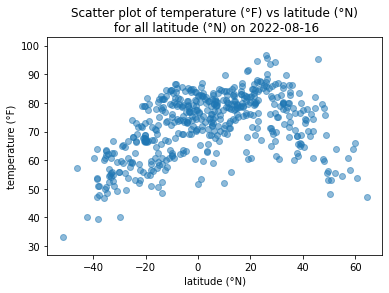

In [11]:
# Scatter plot of temperature vs latititude
scatter(weather_data, 'latitude (°N)', 'temperature (°F)', save=True)

Below plots humidity. There is a noticeable gap in low humidties between 0 and 20 degrees N. Outside of this region though, humidity does not appear to follow any pattern.

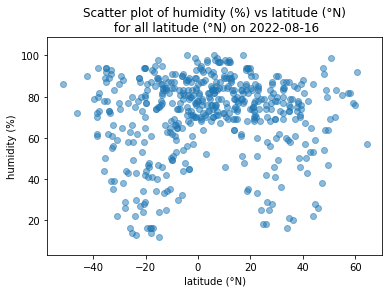

In [12]:
scatter(weather_data, 'latitude (°N)', 'humidity (%)', save=True)

The cloudiness values appear largely skewed either 100% or 0%. While the data is presented as numerical (percentages) it looks more categorical; there are visiable lines around 0%, 25%, 75% and 100%. This coud be because cloudiness is not directly measured and is more or less a subjective quantity assigned by the forecaster. There looks to be a small gap in low cloudiness near 0 to 20 degrees N, similar to the humidity gap but less defined. 

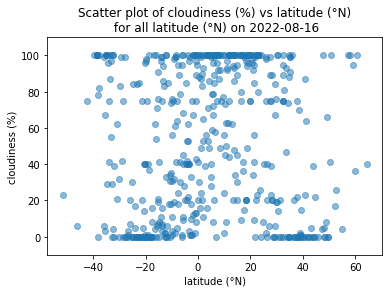

In [13]:
scatter(weather_data, 'latitude (°N)', 'cloudiness (%)', save=True)

There does not seem to be a visable correlation between wind speed and latitude.

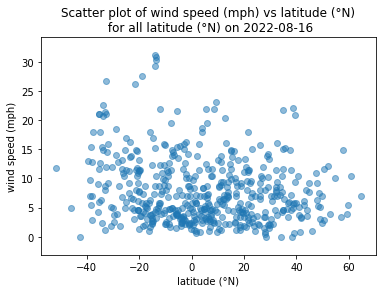

In [14]:
scatter(weather_data, 'latitude (°N)', 'wind speed (mph)', save=True)

The linear regression for temperature vs latitude in the norther hemisphere has a pvalue much less than alpha of 0.05; this means we can reject the null hypothesis than temperature and latitude are not correlated in the norhtern hemisphere. Since the slope of the regression is negative, the temerature generally drops the further north you go. The low r value indicates that the linnear correlation is not strong and that the linnear equation is not a great predictor of temperature. This could be due to the fact that the max temp appears closer to 20 degress N, agian because it is summer in the norther hemisphere, and for values of latitude between 0 and 20 degrees N, temperature is still increasing. 

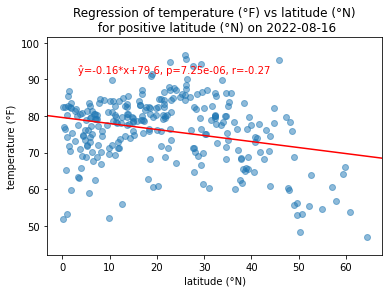

In [15]:
scatter(weather_data, 'latitude (°N)', 'temperature (°F)', regress=True, subset='positive', save=True)

The regression for humidty vs latitude in the northern hemisphere has a very small p value. So again the null hypthesis is rejected again and there is a significant, non zero slope between humidity and latitude. The slope is also negative so further north generally means lower humidity. Again the correlation value is fairly close to zero so R^2 will be small meaning the linnear regression is not predictive. The correlation matches the observation that there is a gap in low humidity near the equator (what we saw in the first humidity plot).

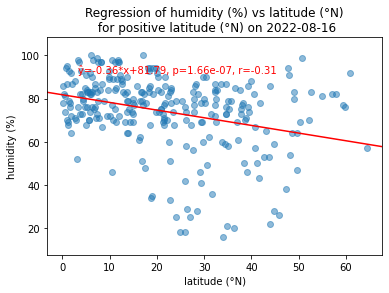

In [16]:
scatter(weather_data, 'latitude (°N)', 'humidity (%)', regress=True, subset='positive', save=True)

The cloudiness vs latitude in the northern hemisphere regression has a small pvalue, which is very small compared to alpha = 0.05; we reject null hypothesis of cloudiness and latitude in northern hemisphere being not correlated. The slope is negative, meaning cloudiness generally decreases as latitude increases. R^2 is again small, so the linnear fit is probably not a great predictor.

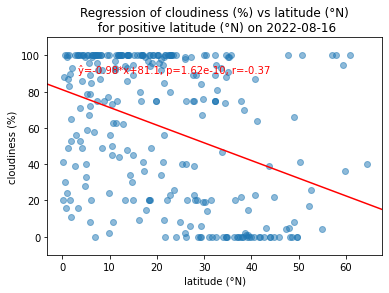

In [17]:
scatter(weather_data, 'latitude (°N)', 'cloudiness (%)', regress=True, subset='positive', save=True)

The linear regression for wind speed vs latitude in northern hemisphere has a pvalue which is larger than alpha=0.05. This means we fail to reject a null hypothesis that wind speed and latitude have a non zero slope. This is in line with our observations of wind speed vs latitude on the whole globe.

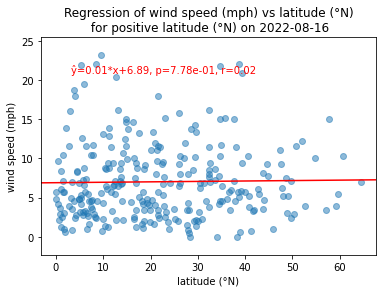

In [18]:
scatter(weather_data, 'latitude (°N)', 'wind speed (mph)', regress=True, subset='positive', save=True)

The linear regression for temperature vs latitude in the southern hemisphere has a very low pvalue which is less than alpha = 0.05. So the null hypothesis that temperature and latitude are not correlated in the southern hemipshere is rejected. The slope of the regression is positive so as latitude increases temperature increases as well. The R^2 value is higher than the regression in the northern hemisphere but still not close to 1. This means the line is a better predictor but still not the most reliable.

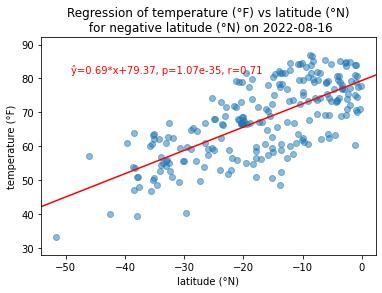

In [19]:
scatter(weather_data, 'latitude (°N)', 'temperature (°F)', regress=True, subset='negative', save=True)

The regerssion for humidity vs latitude in the southern hemisphere has a pvalue which is greater that alpha = 0.05 which means we fail to reject the null hypothesis that the two our not correlated. 

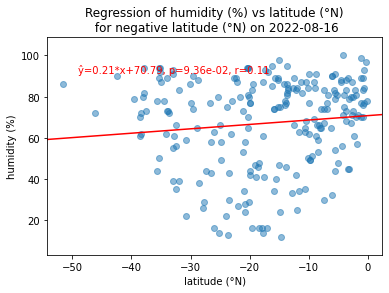

In [20]:
scatter(weather_data, 'latitude (°N)', 'humidity (%)', regress=True, subset='negative', save=True)

There is a similar result for cloudiness and latidue in southern hemisphere; we fail to reject the null hypothesis due to the hugh pvalue. 

Both humidity and cloudiness had strong correlations with latitude in the nothern hemisphere but fail to regject the null in the southern hemisphere. This could be due to the fact that there is a gap in both quantities from 0 to 20 degrees N which is captured in the northern hemisphere but not in the southern. This feature, might be beacuse it is currently summer in the northern hemisphere. 

The regression of wind speed vs latitude in the southern hemisphere fails to reject the null hypothesis which was the same in the norhtern hemipshere. This is in line with our observation that wind wpeed did not seem to have any correlation with latitude.

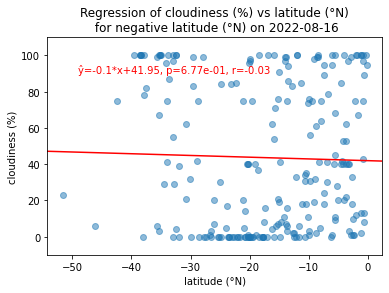

In [21]:
scatter(weather_data, 'latitude (°N)', 'cloudiness (%)', regress=True, subset='negative', save=True)